# Training Model and Model Assessment

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# supress annoying warning about upcoming changes to sklearn's Logit function
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV,  StratifiedKFold, StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier

#import plotly.graph_objs as go
#from plotly.plotly import iplot

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, log_loss, accuracy_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer





## Import Data

In [5]:
#load data
train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values  = pd.read_csv("test_values.csv")

#merge dataframes for analysis to make my life a little easier (merging via the patient id column)
data = pd.merge(train_values, train_labels)

#make copy of data in case of screw up and drop patient id column
patient_id = data['patient_id'].copy()
data = data.drop(['patient_id'], axis = 1)
train = train_values.drop(['patient_id'], axis = 1)
y = train_labels.drop(['patient_id'], axis = 1)

patient_id_test = test_values['patient_id'].copy()
test_data = test_values.drop(['patient_id'], axis = 1)

## Splitting Training data into train and test sets using Stratified Sampling
Using stratified sampling to ensure the categorical variables are proportionally distributed across the training and testing sets

In [6]:
# First split data into training and testing sets and will store test for final evaluation

strat_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in strat_split.split(train, y):
    X_train, X_test = train.loc[train_index], train.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    

In [7]:
X_train.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.513889,130.395833,3.152778,0.694444,0.194444,1.027778,248.083333,0.959722,0.694444,54.736111,150.006944,0.319444
std,0.614352,16.092051,0.903137,0.955498,0.397154,1.003103,54.027123,1.078805,0.462250,9.738530,22.012233,0.467889
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,212.750000,0.000000,0.000000,47.000000,132.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,244.000000,0.750000,1.000000,55.500000,152.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,277.000000,1.600000,1.000000,63.000000,168.000000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000


## Data Preprocessing

In [8]:
# splitting data into categorical, numerical, and binary columns in order to perform the transformations needed for each set
cat_vars = ['thal', 'chest_pain_type', "slope_of_peak_exercise_st_segment"]
binary_vars = list(['fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina'])
num_vars = list(set(X_train.columns.tolist()) - set(cat_vars) - set(binary_vars))

X_train_cat = X_train[cat_vars]
X_train_bin = X_train[binary_vars]
X_train_num = X_train[num_vars]


In [9]:

# create pipe which hot one encodes categorical variables, standardizes numerical variables, and lets the binary variables passthrough untouched
data_pipe = ColumnTransformer([
    ("num", StandardScaler(), num_vars), 
    ("cat", OneHotEncoder(), cat_vars)
], remainder = 'passthrough')


In [10]:

#fit the pipe and transform the data
X_temp = data_pipe.fit_transform(X_train)
X_temp = pd.DataFrame(X_temp)

# add names of the variables back into data since they were removed by the pipe process for model assessment
col_names = num_vars + list(data_pipe.named_transformers_['cat'].get_feature_names(cat_vars)) +  binary_vars
X_temp.columns = col_names

# add back indices
X_temp.index = X_train.index

# check data, all looks good
X_temp.head()
X_temp.shape

# Transform test data for model assessment
X_test_tr = data_pipe.transform(X_test)


,age,serum_cholesterol_mg_per_dl,resting_ekg_results,resting_blood_pressure,max_heart_rate_achieved,num_major_vessels,oldpeak_eq_st_depression,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,fasting_blood_sugar_gt_120_mg_per_dl,sex,exercise_induced_angina
139,-1.106284,-0.540189,0.972598,-0.024684,1.732022,-0.729325,-0.892721,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
0,-1.003241,1.112882,0.972598,-0.149403,0.911440,-0.729325,-0.892721,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
169,0.954582,-0.688779,0.972598,-1.271872,-0.273844,-0.729325,0.781615,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
65,-2.033674,0.629962,0.972598,-0.274121,0.273211,-0.729325,-0.892721,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
98,1.057625,0.388503,-1.028175,1.534301,-0.091492,-0.729325,-0.148571,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


(144, 20)

## Fitting Logistic Regression Model

In [11]:
# Logit function from SKLEARN using l2 penalty
logit = LogisticRegression()
logit.fit(X_temp, y_train)
logit.penalty

# train_preds = logit.predict(X_temp)
preds = cross_val_predict(logit, X_temp, y_train, cv = 10)

pd.DataFrame(logit.predict_proba(X_temp)).head()
y_train.head()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

'l2'

,0,1
0,0.890792,0.109208
1,0.824240,0.175760
2,0.730480,0.269520
3,0.150637,0.849363
4,0.961803,0.038197


,heart_disease_present
139,0
0,0
169,0
65,1
98,0


In [12]:
sm.Logit(y_train, X_temp).fit().summary()

Optimization terminated successfully.
         Current function value: 0.343667
         Iterations 10


C:\Users\Tony\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\Tony\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Tony\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Tony\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     heart_disease_present   No. Observations:                  144
Model:                             Logit   Df Residuals:                      126
Method:                              MLE   Df Model:                           17
Date:                   Mon, 04 Nov 2019   Pseudo R-squ.:                  0.4997
Time:                           14:01:58   Log-Likelihood:                -49.488
converged:                          True   LL-Null:                       -98.922
Covariance Type:               nonrobust   LLR p-value:                 1.441e-13
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                     -0.1919      0.327     -0.586      0.558      -0.833       0.449
serum_cholesterol_mg_per_dl              0.3120      0.271      1.151      0.250      -0.220       0.844
resting_ekg_results                      0.5356      0.293      1.830      0.067      -0.038       1.109
resting_blood_pressure                   0.5001      0.314      1.590      0.112      -0.116       1.116
max_heart_rate_achieved                 -0.4296      0.364     -1.179      0.238      -1.144       0.285
num_major_vessels                        0.9659      0.353      2.737      0.006       0.274       1.658
oldpeak_eq_st_depression                 0.3793      0.413      0.918      0.359      -0.431       1.189
thal_fixed_defect                       -0.7711   1.79e+07  -4.31e-08      1.000   -3.51e+07    3.51e+07
thal_normal                             -0.7064   1.77e+07     -4e-08      1.000   -3.46e+07    3.46e+07
thal_reversible_defect                   0.8931   1.79e+07      5e-08      1.000    -3.5e+07     3.5e+07
chest_pain_type_1                       -1.9567        nan        nan        nan         nan         nan
chest_pain_type_2                       -0.5778        nan        nan        nan         nan         nan
chest_pain_type_3                       -1.1793        nan        nan        nan         nan         nan
chest_pain_type_4                        0.2161        nan        nan        nan         nan         nan
slope_of_peak_exercise_st_segment_1     -1.3761        nan        nan        nan         nan         nan
slope_of_peak_exercise_st_segment_2     -0.5926        nan        nan        nan         nan         nan
slope_of_peak_exercise_st_segment_3      0.1357        nan        nan        nan         nan         nan
fasting_blood_sugar_gt_120_mg_per_dl    -0.6426      0.838     -0.767      0.443      -2.284       0.999
sex                                      1.8535      0.790      2.346      0.019       0.305       3.402
exercise_induced_angina                  0.7342      0.628      1.170      0.242      -0.496       1.964
========================================================================================================
"""

In [13]:

#Confusion Matrix, doesnt look too bad. Pretty high high number of FNs. Nearly 1/4 of positives classified as negatives 
print('In-Sample Confusion Matrix:') 
pd.DataFrame(confusion_matrix(y_train, preds)) 

# Precision and Sensitivity scores. Sensitivity shows result of high number of FNs
print(
    "In-Sample Precision Score:", precision_score(y_train, preds), "\n"
    "In-Sample Sensitivity:", recall_score(y_train, preds)
)

logit_test_preds = logit.predict(X_test_tr)

print("Out of Sample Confusion Matrix:")
pd.DataFrame(confusion_matrix(y_test, logit_test_preds))

print(
    "Out of Sample Precision Score:", precision_score(y_test, logit_test_preds), "\n"
    "Out of Sample Sensitivity:", recall_score(y_test, logit_test_preds)
)

# Performs very well out of sample. Makes no misclassification mistakes when it comes to positives but does have a few false positives

In-Sample Confusion Matrix:


,0,1
0,70,10
1,16,48


In-Sample Precision Score: 0.8275862068965517 
In-Sample Sensitivity: 0.75
Out of Sample Confusion Matrix:


,0,1
0,16,4
1,0,16


Out of Sample Precision Score: 0.8 
Out of Sample Sensitivity: 1.0


<Figure size 576x432 with 0 Axes>

0.921875

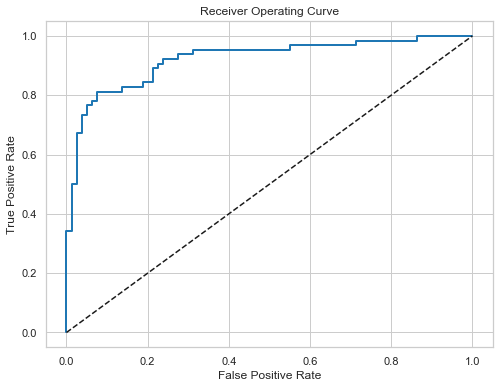

In [14]:


# Want to see the ROC plots and AUC scores to compare classifiers. 

scores = logit.decision_function(X_temp)

fpr, tpr, thresholds = roc_curve(y_train, scores)

def plot_roc_curve(fpr, tpr, color = "#1f77b4", label = None, plt_title = "Receiver Operating Curve"):
    plt.plot(fpr, tpr, linewidth = 2, label = label, color = color)
    plt.plot([0,1], [0,1], "k--")
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(plt_title)
    
    
plt.figure(figsize = (8,6))
plot_roc_curve(fpr, tpr)
roc_auc_score(y_train, scores)
# ROC curve for the default logit function looks ok but could be improved

    0   1
0  67  13
1  16  48
AUC Score: 0.9138671875


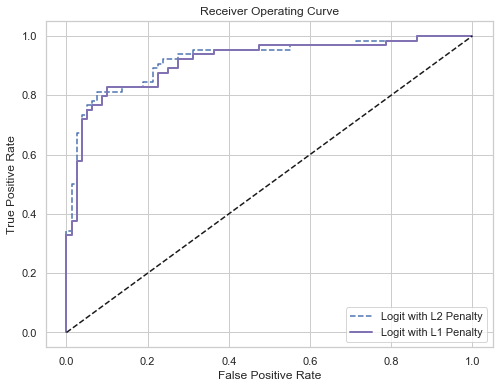

In [15]:
# logit function using l1 penalty
logit_l1 = LogisticRegression(penalty = "l1")

l1_preds = cross_val_predict(logit_l1, X_temp, y_train, cv = 10)

#confusion matrix shows somehow it performs worse than logit with l2 penalty
print(pd.DataFrame(confusion_matrix(y_train, l1_preds)))

logit_l1.fit(X_temp, y_train)
l1_scores = logit_l1.decision_function(X_temp)
print("AUC Score:", roc_auc_score(y_train, l1_scores) )

fpr_l1, tpr_l1, thresholds = roc_curve(y_train, l1_scores)


plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, "b--", label = "Logit with L2 Penalty")
plot_roc_curve(fpr_l1, tpr_l1, color = "m",  label = "Logit with L1 Penalty")
plt.legend(loc = "lower right");

#close but performs worse, lower AUC score

[[69 11]
 [16 48]]
AUC Score: 0.9230468749999999
Precision Score: 0.8421052631578947 
Sensitivity Score: 1.0


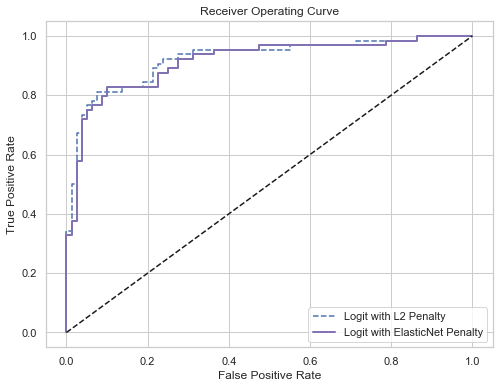

In [16]:
# Try Logit with elastic net penalty (combo of L1 and L2)
logit_en = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.1, C = 1.5)

en_preds = cross_val_predict(logit_en, X_temp, y_train, cv = 10)

print(confusion_matrix(y_train, en_preds))

logit_en.fit(X_temp, y_train)
en_scores = logit_en.decision_function(X_temp)
print("AUC Score:", roc_auc_score(y_train, en_scores))



plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, "b--", label = "Logit with L2 Penalty")
plot_roc_curve(fpr_l1, tpr_l1, color = "m",  label = "Logit with ElasticNet Penalty")
plt.legend(loc = "lower right");


logiten_preds = logit_en.predict(X_test_tr)
pd.DataFrame(confusion_matrix(y_test, logiten_preds))

print("Precision Score:", precision_score(y_test, logiten_preds), "\n"
      "Sensitivity Score:", recall_score(y_test, logiten_preds));

#Performs better than simple logit

In [17]:
# train logisitc regression model with elastic net regularization on whole dataset to make predictions

final_logit_en = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.1, C = 1.5)
final_logit_en.fit(X_temp, y_train)

# make prediction on the new data and output predictions into csv
# final_test = data_pipe.transform(test_data)

# final_preds = final_logit_en.predict_proba(final_test)
# hd = pd.DataFrame(final_preds[:,1])
# hd.columns = ['heart_disease_present']

# output = pd.concat([pd.DataFrame(patient_id_test), hd], axis = 1)
# output.head()

# output.to_csv('submission_logit_en.csv', index = False)

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# make final predicitons on the new data

final_test = data_pipe.transform(test_data)

final_preds = logit.predict_proba(final_test)


hd = pd.DataFrame(final_preds[:,1])
hd.columns = ['heart_disease_present']
hd.head()

patient_id_test.head()

# output = pd.concat([pd.DataFrame(patient_id_test), hd], axis = 1)
# output.head()

# output.to_csv('submission.csv', index = False)

,heart_disease_present
0,0.689240
1,0.081195
2,0.954422
3,0.028220
4,0.925373


0    olalu7
1    z9n6mx
2    5k4413
3    mrg7q5
4    uki4do
Name: patient_id, dtype: object

## Prepare Reduce Variable Set

In [19]:
# drop variables determined to be nonsignificant from data exploration
vars_2_drop = ["serum_cholesterol_mg_per_dl", "resting_ekg_results", "fasting_blood_sugar_gt_120_mg_per_dl", "resting_blood_pressure"]
X_red = X_train.drop(vars_2_drop, axis = 1)


cat_vars = list(set(['thal', 'chest_pain_type', "slope_of_peak_exercise_st_segment"]) - set(vars_2_drop))
binary_vars = list(set(['fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina']) - set(vars_2_drop))
num_vars = list(set(X_train.columns.tolist()) - set(cat_vars) - set(binary_vars) - set(vars_2_drop))

In [20]:
# reinitialize the pipeline for transforming data using reduced variable space

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),      # include imputer in case there exists any missing values in
    ('std_scaler', StandardScaler())
])

preprocess_pipe = ColumnTransformer([
    ("num", num_pipe, num_vars), 
    ("cat", OneHotEncoder(), cat_vars)
], remainder = 'passthrough')

# full_pipe = Pipeline([
#     ('preprocess', preprocess_pipe),
#     ('Logit', LogisticRegression())
#     ])

In [21]:
X_red_tr = preprocess_pipe.fit_transform(X_red)
X_red_tr = pd.DataFrame(X_red_tr)

col_names = num_vars + list(preprocess_pipe.named_transformers_['cat'].get_feature_names(cat_vars)) +  binary_vars
X_red_tr.columns = col_names

# add back indices
X_red_tr.index = X_train.index

# check data, all looks good
X_red_tr.head()
X_red_tr.shape


# transform test set also
X_test_red = X_test.drop(vars_2_drop, axis = 1)
X_test_tr = preprocess_pipe.transform(X_test_red)
X_test_tr = pd.DataFrame(X_test_tr)
X_test_tr.index = X_test.index
X_test_tr.columns = col_names

,age,num_major_vessels,max_heart_rate_achieved,oldpeak_eq_st_depression,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_fixed_defect,thal_normal,thal_reversible_defect,exercise_induced_angina,sex
139,-1.106284,-0.729325,1.732022,-0.892721,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
0,-1.003241,-0.729325,0.911440,-0.892721,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
169,0.954582,-0.729325,-0.273844,0.781615,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
65,-2.033674,-0.729325,0.273211,-0.892721,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
98,1.057625,-0.729325,-0.091492,-0.148571,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


(144, 16)

,age,num_major_vessels,max_heart_rate_achieved,oldpeak_eq_st_depression
age,1.000000,0.338477,-0.419572,0.205058
num_major_vessels,0.338477,1.000000,-0.254248,0.231526
max_heart_rate_achieved,-0.419572,-0.254248,1.000000,-0.372477
oldpeak_eq_st_depression,0.205058,0.231526,-0.372477,1.000000


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text xticklabel objects>)

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

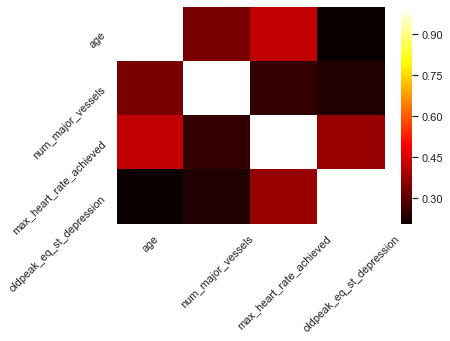

In [22]:
#  Check for any correlations between numerical variables
corr_matrix = pd.DataFrame(np.corrcoef(X_red_tr[num_vars], rowvar = False))
corr_matrix.columns, corr_matrix.index = num_vars, num_vars
corr_matrix
corr_matrix = np.abs(corr_matrix)   # Took the absolute value of the correlations to see if there are highly correlated vars, 
sns.heatmap(corr_matrix, cmap = plt.cm.hot)   # dont care if they are positive or negative
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

# No terribly highly correlated numerical variables

In [23]:
#prepare entire training set and new data for final predictions
X_full_red = train.drop(vars_2_drop, axis = 1)
X_full_transf = preprocess_pipe.fit_transform(X_full_red)

test_data_trans = preprocess_pipe.transform(test_data)

## Fitting Logit with reduced variables

In [24]:
# results = red_logit.fit()
# results.summary()

# Need to find the best parameter for regularization, LASSO performs  variable selection as an added bonus
sm.Logit(y_train, X_red_tr).fit_regularized(alpha = 1).summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4261725785437008
            Iterations: 87
            Function evaluations: 87
            Gradient evaluations: 87


C:\Users\Tony\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Tony\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Tony\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     heart_disease_present   No. Observations:                  144
Model:                             Logit   Df Residuals:                      132
Method:                              MLE   Df Model:                           11
Date:                   Mon, 04 Nov 2019   Pseudo R-squ.:                  0.4394
Time:                           14:02:01   Log-Likelihood:                -55.460
converged:                          True   LL-Null:                       -98.922
Covariance Type:               nonrobust   LLR p-value:                 6.658e-14
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
age                                    -0.0147      0.269     -0.055      0.956      -0.542       0.512
num_major_vessels                       0.7116      0.269      2.649      0.008       0.185       1.238
max_heart_rate_achieved                -0.1905      0.288     -0.661      0.508      -0.755       0.374
oldpeak_eq_st_depression                0.2758      0.326      0.845      0.398      -0.364       0.916
chest_pain_type_1                            0        nan        nan        nan         nan         nan
chest_pain_type_2                            0        nan        nan        nan         nan         nan
chest_pain_type_3                      -0.1628      0.626     -0.260      0.795      -1.391       1.065
chest_pain_type_4                       0.9615      0.621      1.547      0.122      -0.256       2.179
slope_of_peak_exercise_st_segment_1    -0.6847      0.559     -1.225      0.221      -1.780       0.411
slope_of_peak_exercise_st_segment_2          0        nan        nan        nan         nan         nan
slope_of_peak_exercise_st_segment_3          0        nan        nan        nan         nan         nan
thal_fixed_defect                      -0.2413      1.156     -0.209      0.835      -2.508       2.025
thal_normal                            -1.4902      0.692     -2.154      0.031      -2.846      -0.134
thal_reversible_defect                  0.0021      0.840      0.002      0.998      -1.644       1.648
exercise_induced_angina                 0.7001      0.584      1.199      0.231      -0.445       1.845
sex                                     0.4736      0.547      0.867      0.386      -0.598       1.545
=======================================================================================================
"""

In [25]:
sm.Logit(y_train, X_red_tr.drop("age", axis = 1)).fit_regularized(alpha = 1).summary()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4261831380422843
            Iterations: 78
            Function evaluations: 78
            Gradient evaluations: 78


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     heart_disease_present   No. Observations:                  144
Model:                             Logit   Df Residuals:                      133
Method:                              MLE   Df Model:                           10
Date:                   Mon, 04 Nov 2019   Pseudo R-squ.:                  0.4392
Time:                           14:02:01   Log-Likelihood:                -55.474
converged:                          True   LL-Null:                       -98.922
Covariance Type:               nonrobust   LLR p-value:                 2.204e-14
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
num_major_vessels                       0.7078      0.258      2.740      0.006       0.201       1.214
max_heart_rate_achieved                -0.1856      0.275     -0.675      0.500      -0.725       0.353
oldpeak_eq_st_depression                0.2733      0.324      0.844      0.398      -0.361       0.908
chest_pain_type_1                            0        nan        nan        nan         nan         nan
chest_pain_type_2                            0        nan        nan        nan         nan         nan
chest_pain_type_3                      -0.1654      0.626     -0.264      0.792      -1.393       1.062
chest_pain_type_4                       0.9613      0.620      1.550      0.121      -0.254       2.177
slope_of_peak_exercise_st_segment_1    -0.6852      0.559     -1.225      0.220      -1.781       0.411
slope_of_peak_exercise_st_segment_2          0        nan        nan        nan         nan         nan
slope_of_peak_exercise_st_segment_3          0        nan        nan        nan         nan         nan
thal_fixed_defect                      -0.2460      1.146     -0.215      0.830      -2.492       2.000
thal_normal                            -1.4945      0.677     -2.207      0.027      -2.822      -0.167
thal_reversible_defect              -3.882e-17      0.829  -4.68e-17      1.000      -1.625       1.625
exercise_induced_angina                 0.7059      0.568      1.244      0.214      -0.407       1.818
sex                                     0.4715      0.546      0.863      0.388      -0.599       1.542
=======================================================================================================
"""

In [26]:
param_grid = [
    {"penalty":["none"], "solver":["saga"]},
    {"penalty":["l2", "l1"], "C":[0.01, 0.1, 0.5, 1, 10, 20], "max_iter":[500]},
    {"penalty":["elasticnet"], "solver":["saga"], "C":[0.01, 0.1, 0.5, 1, 1.5, 5, 10], 
             "l1_ratio":[0.001, 0.01, 0.1, 0.3, 0.6, 0.9], "max_iter":[500]}
]
logit_red = LogisticRegression()
grid_search = GridSearchCV(logit_red, param_grid, cv = 7, scoring = "neg_log_loss", return_train_score = True)

grid_search.fit(X_red_tr.drop("age", axis = 1), y_train)

GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'penalty': ['none'], 'solver': ['saga']},
                         {'C': [0.01, 0.1, 0.5, 1, 10, 20], 'max_iter': [500],
                          'penalty': ['l2', 'l1']},
                         {'C': [0.01, 0.1, 0.5, 1, 1.5, 5, 10],
                          'l1_ratio': [0.001, 0.01, 0.1, 0.3, 0.6, 0.9],
       

In [27]:
grid_search.best_params_
grid_search.best_estimator_
grid_search.best_estimator_.coef_

# grid_scores = grid_search.cv_results_
# for mean_score, params in zip(grid_scores["mean_test_score"], grid_scores["params"]):
#     print(mean_score, params)

{'C': 0.5,
 'l1_ratio': 0.001,
 'max_iter': 500,
 'penalty': 'elasticnet',
 'solver': 'saga'}

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.001, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

array([[ 0.66285063, -0.26197746,  0.3596635 , -0.33342904, -0.06141214,
        -0.3499381 ,  0.74227028, -0.38339894,  0.20477513,  0.17311187,
        -0.10589845, -0.61933844,  0.72172691,  0.8490644 ,  0.53369907]])

Best logistic regression model chosen through hypertuning used **elastic net regularization with an l1 ratio of 0.1 and regularization factor of 10 (C = 0.1)**. In addition to getting the highest precision score, it performed some variable selection. It determine age was not significant (as suspected) and a category from the thal and slope of peak ST segment variables. I am more hesitant about the later 2 exclusions since they are part oof categorical variables and is not wise to essentially just drop 2 levels. 

In [38]:
final_logit_red = grid_search.best_estimator_
train_preds = final_logit_red.predict(X_red_tr.drop("age", axis = 1))

pd.DataFrame(confusion_matrix(y_train, train_preds))
print("Log Loss Score:", log_loss(y_train, final_logit_red.predict_proba(X_red_tr.drop("age", axis = 1))) )

print("Accuracy Score:", accuracy_score(y_train, train_preds))


test_preds = final_logit_red.predict(X_test_tr.drop("age", axis = 1))
pd.DataFrame(confusion_matrix(y_test, test_preds))
print("Log Loss Score:", log_loss(y_test, final_logit_red.predict_proba(X_test_tr.drop("age", axis = 1))) )

print("Accuracy Score:", accuracy_score(y_test, test_preds))

,0,1
0,72,8
1,12,52


Log Loss Score: 0.38093696346296624
Accuracy Score: 0.8611111111111112


,0,1
0,16,4
1,0,16


Log Loss Score: 0.2807435393697646
Accuracy Score: 0.8888888888888888


In [29]:
#retrain model on full dataset

# final_logit_red.fit(X_full_transf, y)

# full_preds = final_logit_red.predict(X_full_transf)

# pd.DataFrame(confusion_matrix(y, full_preds))

# roc_auc_score(y, full_preds)
# precision_score(y, full_preds)
# recall_score(y, full_preds)

# log_loss(y, final_logit_red.predict_proba(X_full_transf))

In [30]:

# test_probs = pd.DataFrame( final_logit_red.predict_proba(test_data_trans)[:,1] )
# test_probs.columns = ['heart_disease_present']

# output = pd.concat([pd.DataFrame(patient_id_test), test_probs], axis = 1)
# output.head()

# output.to_csv('submission_logit_en_red.csv', index = False)

## Random Forest

In [31]:
X_red_tr.head()
X_test_tr.head()

,age,num_major_vessels,max_heart_rate_achieved,oldpeak_eq_st_depression,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_fixed_defect,thal_normal,thal_reversible_defect,exercise_induced_angina,sex
139,-1.106284,-0.729325,1.732022,-0.892721,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
0,-1.003241,-0.729325,0.911440,-0.892721,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
169,0.954582,-0.729325,-0.273844,0.781615,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
65,-2.033674,-0.729325,0.273211,-0.892721,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
98,1.057625,-0.729325,-0.091492,-0.148571,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,age,num_major_vessels,max_heart_rate_achieved,oldpeak_eq_st_depression,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_fixed_defect,thal_normal,thal_reversible_defect,exercise_induced_angina,sex
24,1.572842,-0.729325,-0.319432,-0.892721,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
173,-0.384981,-0.729325,1.048204,0.595578,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
81,-0.075851,0.320903,-1.687067,0.409541,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
160,-0.591068,-0.729325,0.957028,-0.334609,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
35,-0.694111,-0.729325,1.640846,-0.892721,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [32]:
rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X_red_tr, y_train)
rf_preds = rf_model.predict(X_red_tr)

# Random Forest off the bat performs better than logistic regression. Maybe a case of perfectly seperable classes
print("Confusion Matrix on training set")
pd.DataFrame(confusion_matrix(y_train, rf_preds))


rf_test_preds = rf_model.predict(X_test_tr)
print("Confusion Matrix on test set")
pd.DataFrame(confusion_matrix(y_test, rf_test_preds))

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tony\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Confusion Matrix on training set


,0,1
0,80,0
1,1,63


Confusion Matrix on test set


,0,1
0,17,3
1,2,14


In [33]:
# Fine tune model
rf_model = RandomForestClassifier(random_state = 42)

param_grid = [
    {"max_features":["auto", None], "n_estimators":[10, 50, 100, 200], "max_features":[2,3,4,5]},
    {"bootstrap":[False],"n_estimators":[10, 50, 100, 200], "max_features":[2,3,4,5]}
]

rf_grid = GridSearchCV(rf_model, param_grid, cv = 5, scoring = "neg_log_loss", return_train_score=True)
rf_grid.fit(X_red_tr, y_train)

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{

In [34]:
rf_grid.best_params_

{'max_features': 5, 'n_estimators': 100}

In [35]:
rf_best = rf_grid.best_estimator_

pd.DataFrame(confusion_matrix(y_train, rf_best.predict(X_red_tr) ))
 
rf_test_preds = rf_best.predict(X_test_tr)
pd.DataFrame(confusion_matrix(y_test, rf_test_preds ))
# Performs very well

log_loss(y_train, rf_best.predict_proba(X_red_tr))

log_loss(y_test, rf_best.predict_proba(X_test_tr))

,0,1
0,80,0
1,0,64


,0,1
0,15,5
1,2,14


0.12246648208143945

0.35541509925367754

In [36]:
# retrain on entire dataset
# rf_best.fit(X_full_transf, y)

# test_probs_rf = pd.DataFrame( rf_best.predict_proba(test_data_trans)[:,1])

# test_probs.columns = ['heart_disease_present']

# output = pd.concat([pd.DataFrame(patient_id_test), test_probs], axis = 1)
# output.head()

# output.to_csv('submission_RF.csv', index = False)